In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import os

import torch
from sklearn.linear_model import LinearRegression
from datasets import ArtificialDataset
from cross_moment import get_beta

import matplotlib.pyplot as plt

## Exponential Distribution

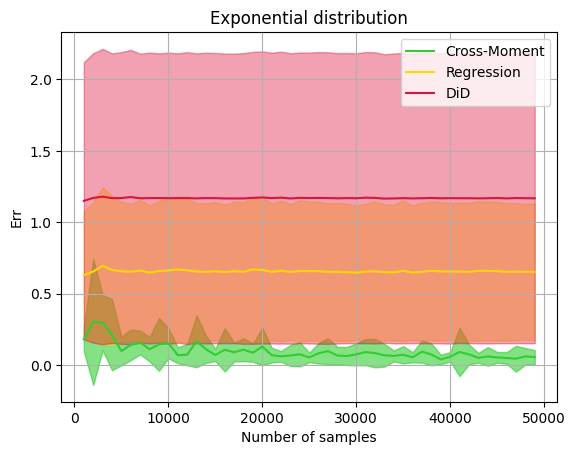

In [3]:
dist_name = "Exponential"
seed = 1999
deg = 2
np.random.seed(seed)

max_samples = 50000

betas_true = np.zeros(10, dtype=float)
betas = {}
betas_reg = {}
betas_did = {}
scale_noise = 0.1
for i in range(10):
    alpha_d, alpha_z, beta, gamma = 0, 0, 0, 0
    while abs(alpha_d) < 0.2:
        alpha_d = -2 + 4 * np.random.rand()

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        alpha_z = alpha_d * scale

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        beta = alpha_d * scale

    scale = 0
    while abs(scale) < 0.5 or abs(scale) > 2:
        scale = -2 + 4 * np.random.rand()
        gamma = alpha_z * scale
        
    betas_true[i] = beta

    for n_samples in range(1000, max_samples, 1000):
        seed = np.random.randint(1000)
        rate_u, rate_d, rate_z, rate_y = 0, 0, 0, 0
        var_u, var_d, var_z, var_y = 0, 0, 0, 0
        while var_u < 1:
            var_u = 10 * np.random.rand()
        var_d = scale_noise * var_u
        var_z = scale_noise * var_u
        var_y = scale_noise * var_u

        rate_u = 1./var_u
        rate_d = 1./var_d
        rate_z = 1./var_z
        rate_y = 1./var_y
        
        dist_param = {
            "U": {"rate": rate_u},
            "D": {"rate": rate_d},
            "Z": {"rate": rate_z},
            "Y": {"rate": rate_y},
        }
        dist_conf = (dist_name, dist_param)

        # Get synthetic data
        artific_dataset = ArtificialDataset(alpha_z, alpha_d, beta, gamma, n_samples, dist_conf, seed)
        Z = artific_dataset.Z.numpy()
        D = artific_dataset.D.numpy()
        Y = artific_dataset.Y.numpy()

        if n_samples not in betas.keys():
            betas[n_samples] = []
        betas[n_samples].append(get_beta(Z, D, Y, deg))
        
        # Prepare dataset of simple linear regression
        data_tmp = np.concatenate((np.expand_dims(Z, axis=1), np.expand_dims(D, axis=1)), axis=1)

        # Estimate beta with simple linear regression
        reg = LinearRegression().fit(data_tmp, Y)
        if n_samples not in betas_reg.keys():
            betas_reg[n_samples] = []
        betas_reg[n_samples].append(reg.coef_[-1])
        
        # Prepare dataset of DiD estimation
        T_z = np.zeros(len(Z), dtype=np.float32)
        T_y = np.ones(len(Y), dtype=np.float32)
        T = np.concatenate((T_z, T_y))
        D_new = np.concatenate((D, D))
        TD = np.concatenate((T_z, D))
        Y_new = np.concatenate((Z, Y))
        data_did =  np.concatenate((np.expand_dims(T, 1), np.expand_dims(D_new, 1), np.expand_dims(TD,1)), axis=1)

        # Estimate beta with DiD
        reg = LinearRegression().fit(data_did, Y_new)
        if n_samples not in betas_did.keys():
            betas_did[n_samples] = []
        betas_did[n_samples].append(reg.coef_[-1])
    
# Preprocess data to make a plot
x = list(range(1000, max_samples, 1000))
y = np.zeros(len(x))
yerr = np.zeros(len(x))
y_reg = np.zeros(len(x))
yerr_reg = np.zeros(len(x))
y_did = np.zeros(len(x))
yerr_did = np.zeros(len(x))


for i, n_samples in enumerate(range(1000, max_samples, 1000)):
    x[i] = n_samples
    
    estimates = np.abs((np.array(betas[n_samples]) - betas_true) / betas_true)
    y[i] = np.mean(estimates)
    yerr[i] = np.std(estimates)
    
    estimates = np.abs((np.array(betas_reg[n_samples]) - betas_true) / betas_true)
    y_reg[i] = np.mean(estimates)
    yerr_reg[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_did[n_samples]) - betas_true) / betas_true)
    y_did[i] = np.mean(estimates)
    yerr_did[i] = np.std(estimates)

# Plot the results
eps=0.3
plt.title("Exponential distribution")
plt.xlabel("Number of samples")
plt.ylabel("Err")
plt.plot(x, y, label="Cross-Moment", color="limegreen")
plt.fill_between(x, y - yerr, y + yerr, alpha=0.6, color="limegreen")
plt.plot(x, y_reg, label="Regression", color="gold")
plt.fill_between(x, y_reg - yerr_reg, y_reg + yerr_reg, alpha=0.4, color="gold")
plt.plot(x, y_did, label="DiD", color="crimson")
plt.fill_between(x, y_did - yerr_did, y_did + yerr_did, alpha=0.4, color="crimson")
plt.legend(loc="upper right")
plt.grid()
# plt.ylim(0, 1)
plt.savefig("./figures/exponential_samples.png")
plt.show()

## Fast Food Dataset

In [4]:
col_names = [
    "ID", "CHAIN", "CO_OWNED", "STATE",
    "SOUTHJ", "CENTRALJ", "NORTHJ", "PA1",
    "PA2", "SHORE",
    "NCALLS", "EMPFT", "EMPPT", "NMGRS",
    "WAGE_ST", "INCTIME", "FIRSTINC",
    "BONUS", "PCTAFF", "MEALS", "OPEN",
    "HRSOPEN", "PSODA", "PFRY", "PENTREE",
    "NREGS", "NREGS11",
    "TYPE2", "STATUS2", "DATE2", "NCALLS2",
    "EMPFT2", "EMPPT2", "NMGRS2", "WAGE_ST2",
    "INCTIME2", "FIRSTIN2", "SPECIAL2", "MEALS2",
    "OPEN2R", "HRSOPEN2", "PSODA2", "PFRY2",
    "PENTREE2", "NREGS2", "NREGS112"
]

col_names_pre = [
    "ID", "CHAIN", "CO_OWNED", "STATE",
    "SOUTHJ", "CENTRALJ", "NORTHJ", "PA1",
    "PA2", "SHORE",
    "EMPFT", "EMPPT",
    "WAGE_ST", "INCTIME", "FIRSTINC",
    "OPEN", "HRSOPEN", "PSODA", "PFRY", 
    "PENTREE"
]

col_names_post = [
    "ID", "CHAIN", "CO_OWNED", "STATE",
    "SOUTHJ", "CENTRALJ", "NORTHJ", "PA1",
    "PA2", "SHORE",
    "EMPFT2", "EMPPT2", 
    "WAGE_ST2", "INCTIME2", "FIRSTIN2",
    "OPEN2R", "HRSOPEN2", "PSODA2", "PFRY2",
    "PENTREE2"
]

In [5]:
file = "data/njmin/public.dat"
file_path = os.path.join(os.getcwd(), file)
df = pd.read_table(file_path, delim_whitespace=True, names=col_names, na_values='.')

In [6]:
data_pre = df[col_names_pre].copy()
data_post = df[col_names_post].copy()
data_post.columns = data_pre.columns
rate = 0.5

tmp = len(data_pre)*[0.]
data_pre.insert(1, "Treatment", tmp)
data_pre["Empl"] = data_pre["EMPFT"] + data_pre["EMPPT"]*rate

tmp = len(data_post)*[1.]
data_post.insert(1, "Treatment", tmp)
data_post["Empl"] = data_post["EMPFT"] + data_post["EMPPT"]*rate

data_pre["PostTreatment"] = data_pre["STATE"]*data_pre["Treatment"]
data_post["PostTreatment"] = data_post["STATE"]*data_post["Treatment"]

mask = data_post["Empl"]==0
mask = ~mask
data_pre = data_pre[mask]
data_post = data_post[mask]

In [7]:
data_pre_new = data_pre.drop(["ID", "CHAIN", "EMPFT", "EMPPT"], axis=1)
data_post_new = data_post.drop(["ID", "CHAIN", "EMPFT", "EMPPT"], axis=1)
mask = data_pre_new.isnull().any(axis=1) | data_post_new.isnull().any(axis=1)
mask = ~mask

data_pre_new = data_pre_new[mask]
data_post_new = data_post_new[mask]

### Estimate $\beta$ with access to the covariates

In [8]:
data = pd.concat([data_pre_new, data_post_new], ignore_index=True)

In [9]:
X = data.drop(["Empl"], axis=1).to_numpy()
Y = data["Empl"].to_numpy()

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
beta = reg.coef_[-1]
print("Beta estimated by TWFE: ", beta)

Beta estimated by TWFE:  2.6843899743729422


In [10]:
reg = LinearRegression().fit(X, Y)
Z = data_pre_new["Empl"].to_numpy() - np.matmul(X[:len(data_pre_new), :-1], reg.coef_[:-1])
X_new = data_pre_new["STATE"].to_numpy(dtype=np.float32)
Y = data_post_new["Empl"].to_numpy() - np.matmul(X[len(data_pre_new):, :-1], reg.coef_[:-1])

Z -= np.mean(Z)
X_new -= np.mean(X_new)
Y -= np.mean(Y)

max_deg = 12
betas_est = np.zeros(max_deg-2)

for deg in range(2, max_deg):
    beta = get_beta(Z, X_new, Y, deg)
    betas_est[deg-2] = beta

print("Beta estimated by cross-moment method:", betas_est[0])



Beta estimated by cross-moment method: 2.6843904385498703


### Estimate $\beta$ without access to the covariates

In [11]:
data_pre = df[col_names_pre].copy()
data_post = df[col_names_post].copy()
data_post.columns = data_pre.columns
rate = 0.5

tmp = len(data_pre)*[0.]
data_pre.insert(1, "Treatment", tmp)
data_pre["Empl"] = data_pre["EMPFT"] + data_pre["EMPPT"]*rate

tmp = len(data_post)*[1.]
data_post.insert(1, "Treatment", tmp)
data_post["Empl"] = data_post["EMPFT"] + data_post["EMPPT"]*rate

data_pre["PostTreatment"] = data_pre["STATE"]*data_pre["Treatment"]
data_post["PostTreatment"] = data_post["STATE"]*data_post["Treatment"]

mask = data_post["Empl"]==0
mask = ~mask
data_pre = data_pre[mask]
data_post = data_post[mask]

data_pre = data_pre.drop(["ID", "CHAIN", "EMPFT", "EMPPT"], axis=1)
data_post = data_post.drop(["ID", "CHAIN", "EMPFT", "EMPPT"], axis=1)
mask = data_pre.isnull().any(axis=1) | data_post.isnull().any(axis=1)
mask = ~mask

data_pre = data_pre[mask]
data_post = data_post[mask]

In [12]:
data_pre_new = data_pre[["Treatment", "STATE", "PostTreatment", "Empl"]]
data_post_new = data_post[["Treatment", "STATE", "PostTreatment", "Empl"]]

In [13]:
data = pd.concat([data_pre_new, data_post_new], ignore_index=True)

X = data.drop(["Empl"], axis=1).to_numpy()
Y = data["Empl"].to_numpy()

reg = LinearRegression().fit(X, Y)
reg.score(X, Y)
beta = reg.coef_[-1]
print("Beta estimate by TWFE: ", beta)

Beta estimate by TWFE:  3.2495079249974137


In [14]:
Z = data_pre_new["Empl"].to_numpy()
X = data_pre_new["STATE"].to_numpy(dtype=np.float32)
Y = data_post_new["Empl"].to_numpy()

Z -= np.mean(Z)
X -= np.mean(X)
Y -= np.mean(Y)

In [15]:
deg = 2
beta = get_beta(Z, X, Y, deg)
print(f"Beta estimeted by cross-moment method {beta}")


Beta estimeted by cross-moment method 4.030637938383672


## Two Proxy Method vs Cross-Moment Method

### Exponential distribution


In [16]:
import numpy as np
import random

import torch
from datasets import ArtificialDataset
from src.cross_moment import get_beta, get_beta_2proxies, get_beta_sensor_fusion

import matplotlib.pyplot as plt

#### Performance vs Number of samples

In [17]:
dist_name = "Exponential"
seed = 1999
deg = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

max_samples = 50000

betas_true = np.zeros(10, dtype=float)
betas_est1 = {}
betas_est2 = {}
betas_est_sensor_fusion = {}
betas_est_2proxies = {}
betas_est_best = {}
scale_noise = 0.1
scale_noise_Z = 0.1
scale_noise_W = 10
for i in range(10):
    
    alpha_d, alpha_z, beta, gamma = 0, 0, 0, 0
    while abs(alpha_d) < 0.2:
        alpha_d = -2 + 4 * np.random.rand()

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        alpha_z = alpha_d * scale

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        beta = alpha_d * scale

    scale = 0
    while abs(scale) < 0.5 or abs(scale) > 2:
        scale = -2 + 4 * np.random.rand()
        gamma = alpha_z * scale
        
    betas_true[i] = beta

    for n_samples in range(1000, max_samples, 2000):
        seed = np.random.randint(1000)

         # Initialize variances randomly
        rate_u, rate_d, rate_z, rate_w, rate_y = 0, 0, 0, 0, 0
        var_u, var_d, var_z, var_w, var_y = 0, 0, 0, 0, 0
        while var_u < 1:
            var_u = 10 * np.random.rand()
        var_d = scale_noise * var_u
        var_z = scale_noise_Z * var_u
        var_y = scale_noise * var_u
        var_w = scale_noise_W * var_u

        rate_u = 1./var_u
        rate_d = 1./var_d
        rate_z = 1./var_z
        rate_w = 1./var_w
        rate_y = 1./var_y
        
        dist_param = {
            "U": {"rate": rate_u},
            "D": {"rate": rate_d},
            "Z": {"rate": rate_z},
            "Y": {"rate": rate_y},
        }
        dist_conf = (dist_name, dist_param)

        # Get synthetic data
        artific_dataset = ArtificialDataset(alpha_z, alpha_d, beta, gamma, n_samples, dist_conf, seed)
        Z = artific_dataset.Z.numpy()
        D = artific_dataset.D.numpy()
        Y = artific_dataset.Y.numpy()
        eps_u = artific_dataset.eps_u.numpy()

        dist_w = torch.distributions.exponential.Exponential(rate=rate_w)
        eps_w = dist_w.sample([n_samples]).numpy()
        eps_w -= np.mean(eps_w)
        W = eps_u*alpha_z + eps_w

        # Estimate beta with Z
        beta_est1 = get_beta(Z, D, Y, deg)
        if n_samples not in betas_est1.keys():
            betas_est1[n_samples] = []
        betas_est1[n_samples].append(beta_est1)

        # Estimate beta with W
        beta_est2 = get_beta(W, D, Y, deg)
        if n_samples not in betas_est2.keys():
            betas_est2[n_samples] = []
        betas_est2[n_samples].append(beta_est2)

        # Estimate beta with cross-moments sensor fusion
        betas_sensor_fusion = get_beta_sensor_fusion(W, Z, D, Y, deg)
        if n_samples not in betas_est_sensor_fusion.keys():
            betas_est_sensor_fusion[n_samples] = []
        betas_est_sensor_fusion[n_samples].append(betas_sensor_fusion)

        # Estimate beta with two-proxy method
        if n_samples not in betas_est_2proxies.keys():
            betas_est_2proxies[n_samples] = []
        beta_est_2proxies = get_beta_2proxies(Z, W, D, Y)
        betas_est_2proxies[n_samples].append(beta_est_2proxies)

In [18]:
# Preprocess data to make a plot
x = list(range(1000, max_samples, 2000))

y_est1 = np.zeros(len(x))
yerr_est1 = np.zeros(len(x))

y_est2 = np.zeros(len(x))
yerr_est2 = np.zeros(len(x))

y_est_sensor_fusion = np.zeros(len(x))
yerr_est_sensor_fusion = np.zeros(len(x))

y_est_2proxies = np.zeros(len(x))
yerr_est_2proxies = np.zeros(len(x))

for i, n_samples in enumerate(range(1000, max_samples, 2000)):
    x[i] = n_samples
    
    estimates = np.abs((np.array(betas_est1[n_samples]) - betas_true) / betas_true)
    y_est1[i] = np.mean(estimates)
    yerr_est1[i] = np.std(estimates)
    
    estimates = np.abs((np.array(betas_est2[n_samples]) - betas_true) / betas_true)
    y_est2[i] = np.mean(estimates)
    yerr_est2[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_sensor_fusion[n_samples]) - betas_true) / betas_true)
    y_est_sensor_fusion[i] = np.mean(estimates)
    yerr_est_sensor_fusion[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_2proxies[n_samples]) - betas_true) / betas_true)
    y_est_2proxies[i] = np.mean(estimates)
    yerr_est_2proxies[i] = np.std(estimates)

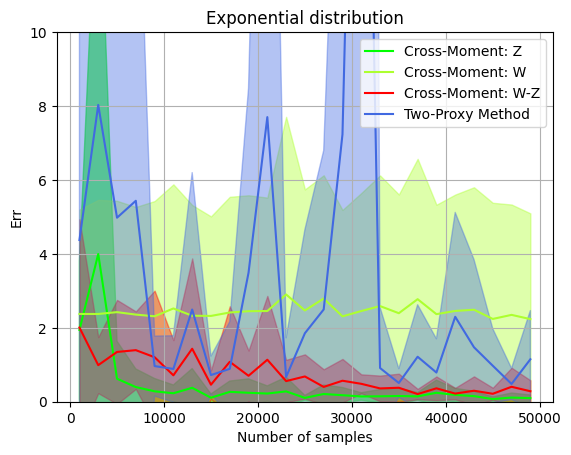

In [19]:
# Plot the results
eps=0.3
plt.title("Exponential distribution")
plt.xlabel("Number of samples")
plt.ylabel("Err")
plt.plot(x, y_est1, label="Cross-Moment: Z", color="lime")
plt.fill_between(x, y_est1 - yerr_est1, y_est1 + yerr_est1, alpha=0.6, color="lime")

plt.plot(x, y_est2, label="Cross-Moment: W", color="greenyellow")
plt.fill_between(x, y_est2 - yerr_est2, y_est2 + yerr_est2, alpha=0.4, color="greenyellow")

plt.plot(x, y_est_sensor_fusion, label="Cross-Moment: W-Z", color="red")
plt.fill_between(x, y_est_sensor_fusion - yerr_est_sensor_fusion, y_est_sensor_fusion + yerr_est_sensor_fusion, alpha=0.4, color="red")

plt.plot(x, y_est_2proxies, label="Two-Proxy Method", color="royalblue")
plt.fill_between(x, y_est_2proxies - yerr_est_2proxies, y_est_2proxies + yerr_est_2proxies, alpha=0.4, color="royalblue")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 10)
plt.savefig("./figures/comparison_2proxies.png")
plt.show()

#### Performance vs SNR rate ($W$)

In [20]:
from src.cross_moment import get_beta, get_beta_2proxies, get_beta_sensor_fusion

In [21]:
dist_name = "Exponential"
seed = 1999
deg = 2
np.random.seed(seed)

num_points = 25
n_samples = 10000

betas_true = np.zeros(10, dtype=float)
betas_est1 = {}
betas_est2 = {}
betas_est_sensor_fusion = {}
betas_est_2proxies = {}
betas_est_best = {}
scale_noise = 0.1
scale_noise_Z = 0.1
for i in range(10):
    alpha_d, alpha_z, beta, gamma = 0, 0, 0, 0
    while abs(alpha_d) < 0.2:
        alpha_d = -2 + 4 * np.random.rand()

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        alpha_z = alpha_d * scale

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        beta = alpha_d * scale

    scale = 0
    while abs(scale) < 0.5 or abs(scale) > 2:
        scale = -2 + 4 * np.random.rand()
        gamma = alpha_z * scale
        
    betas_true[i] = beta

    for scale_noise_W in np.linspace(1, 10, num=num_points):
        seed = np.random.randint(1000)

        # Initialize variances randomly
        rate_u, rate_d, rate_z, rate_w, rate_y = 0, 0, 0, 0, 0
        var_u, var_d, var_z, var_w, var_y = 0, 0, 0, 0, 0
        while var_u < 1:
            var_u = 10 * np.random.rand()
        var_d = scale_noise * var_u
        var_z = scale_noise_Z * var_u
        var_y = scale_noise * var_u
        var_w = scale_noise_W * var_u

        rate_u = 1./var_u
        rate_d = 1./var_d
        rate_z = 1./var_z
        rate_w = 1./var_w
        rate_y = 1./var_y
        
        dist_param = {
            "U": {"rate": rate_u},
            "D": {"rate": rate_d},
            "Z": {"rate": rate_z},
            "Y": {"rate": rate_y},
        }
        dist_conf = (dist_name, dist_param)

        # Get synthetic data
        artific_dataset = ArtificialDataset(alpha_z, alpha_d, beta, gamma, n_samples, dist_conf, seed)
        Z = artific_dataset.Z.numpy()
        D = artific_dataset.D.numpy()
        Y = artific_dataset.Y.numpy()
        eps_u = artific_dataset.eps_u.numpy()

        dist_w = torch.distributions.exponential.Exponential(rate=rate_w)
        eps_w = dist_w.sample([n_samples]).numpy()
        eps_w -= np.mean(eps_w)
        W = eps_u*alpha_z + eps_w

        # Estimate beta with Z
        beta_est1 = get_beta(Z, D, Y, deg)
        if scale_noise_W not in betas_est1.keys():
            betas_est1[scale_noise_W] = []
        betas_est1[scale_noise_W].append(beta_est1)

        # Estimate beta with W
        beta_est2 = get_beta(W, D, Y, deg)
        if scale_noise_W not in betas_est2.keys():
            betas_est2[scale_noise_W] = []
        betas_est2[scale_noise_W].append(beta_est2)

        # Estimate beta with cross-moments sensor fusion
        betas_sensor_fusion = get_beta_sensor_fusion(W, Z, D, Y, deg)
        if scale_noise_W not in betas_est_sensor_fusion.keys():
            betas_est_sensor_fusion[scale_noise_W] = []
        betas_est_sensor_fusion[scale_noise_W].append(betas_sensor_fusion)

        # Estimate beta with two-proxy method
        if scale_noise_W not in betas_est_2proxies.keys():
            betas_est_2proxies[scale_noise_W] = []
        beta_est_2proxies = get_beta_2proxies(Z, W, D, Y)
        betas_est_2proxies[scale_noise_W].append(beta_est_2proxies)

In [22]:
# Preprocess data to make a plot
x = list(np.linspace(1, 10, num=num_points))

y_est1 = np.zeros(len(x))
yerr_est1 = np.zeros(len(x))

y_est2 = np.zeros(len(x))
yerr_est2 = np.zeros(len(x))

y_est_sensor_fusion = np.zeros(len(x))
yerr_est_sensor_fusion = np.zeros(len(x))

y_est_2proxies = np.zeros(len(x))
yerr_est_2proxies = np.zeros(len(x))

for i, scale_noise_W in enumerate(np.linspace(1, 10, num=num_points)):
    x[i] = scale_noise_W
    
    estimates = np.abs((np.array(betas_est1[scale_noise_W]) - betas_true) / betas_true)
    y_est1[i] = np.mean(estimates)
    yerr_est1[i] = np.std(estimates)
    
    estimates = np.abs((np.array(betas_est2[scale_noise_W]) - betas_true) / betas_true)
    y_est2[i] = np.mean(estimates)
    yerr_est2[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_sensor_fusion[scale_noise_W]) - betas_true) / betas_true)
    y_est_sensor_fusion[i] = np.mean(estimates)
    yerr_est_sensor_fusion[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_2proxies[scale_noise_W]) - betas_true) / betas_true)
    y_est_2proxies[i] = np.mean(estimates)
    yerr_est_2proxies[i] = np.std(estimates)

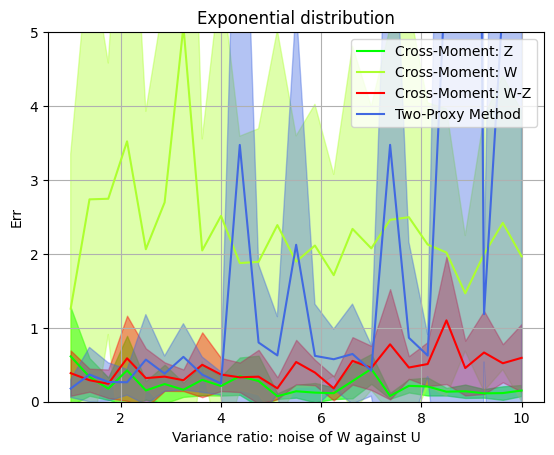

In [23]:
# Plot the results
eps=0.3
plt.title("Exponential distribution")
plt.xlabel("Variance ratio: noise of W against U")
plt.ylabel("Err")
plt.plot(x, y_est1, label="Cross-Moment: Z", color="lime")
plt.fill_between(x, y_est1 - yerr_est1, y_est1 + yerr_est1, alpha=0.6, color="lime")

plt.plot(x, y_est2, label="Cross-Moment: W", color="greenyellow")
plt.fill_between(x, y_est2 - yerr_est2, y_est2 + yerr_est2, alpha=0.4, color="greenyellow")

plt.plot(x, y_est_sensor_fusion, label="Cross-Moment: W-Z", color="red")
plt.fill_between(x, y_est_sensor_fusion - yerr_est_sensor_fusion, y_est_sensor_fusion + yerr_est_sensor_fusion, alpha=0.4, color="red")

plt.plot(x, y_est_2proxies, label="Two-Proxy Method", color="royalblue")
plt.fill_between(x, y_est_2proxies - yerr_est_2proxies, y_est_2proxies + yerr_est_2proxies, alpha=0.4, color="royalblue")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 5)
plt.savefig("./figures/comparison_2proxies_rate.png")
plt.show()

### Uniform distibution 

In [24]:
from datasets import ArtificialDataset
from src.cross_moment import get_beta, get_beta_2proxies, get_beta_sensor_fusion

#### Performance vs Number of samples

In [25]:
dist_name = "Uniform"
seed = 1999
deg = 3
np.random.seed(seed)

max_samples = 50000

betas_true = np.zeros(10, dtype=float)
betas_est1 = {}
betas_est2 = {}
betas_est_sensor_fusion = {}
betas_est_2proxies = {}
betas_est_best = {}
scale_noise = 0.1
scale_noise_Z = 0.1
scale_noise_W = 10
for i in range(10):
    alpha_d, alpha_z, beta, gamma = 0, 0, 0, 0
    while abs(alpha_d) < 0.2:
        alpha_d = -2 + 4 * np.random.rand()

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        alpha_z = alpha_d * scale

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        beta = alpha_d * scale

    scale = 0
    while abs(scale) < 0.5 or abs(scale) > 2:
        scale = -2 + 4 * np.random.rand()
        gamma = alpha_z * scale
        
    betas_true[i] = beta

    for n_samples in range(1000, max_samples, 2000):
        seed = np.random.randint(1000)
        
        # Initialize variances randomly
        var_u, var_d, var_z, var_w, var_y = 0, 0, 0, 0, 0
        while var_u < 1/3:
            var_u = 1/3 * 100 * np.random.rand()
        var_d = scale_noise * var_u
        var_z = scale_noise_Z * var_u
        var_y = scale_noise * var_u
        var_w = scale_noise_W * var_u

        radius_u = np.sqrt(var_u * 12)
        radius_d = np.sqrt(var_d * 12)
        radius_z = np.sqrt(var_z * 12)
        radius_w = np.sqrt(var_w * 12)
        radius_y = np.sqrt(var_y * 12)
        
        dist_param = {
            "U": {"low": -radius_u, "high": radius_u},
            "D": {"low": -radius_d, "high": radius_d},
            "Z": {"low": -radius_z, "high": radius_z},
            "Y": {"low": -radius_y, "high": radius_y},
        }
        dist_conf = (dist_name, dist_param)

        # Get synthetic data
        artific_dataset = ArtificialDataset(alpha_z, alpha_d, beta, gamma, n_samples, dist_conf, seed)
        Z = artific_dataset.Z.numpy()
        D = artific_dataset.D.numpy()
        Y = artific_dataset.Y.numpy()
        eps_u = artific_dataset.eps_u.numpy()

        dist_w = torch.distributions.uniform.Uniform(low=-radius_w, high=radius_w)
        eps_w = dist_w.sample([n_samples]).numpy()
        eps_w -= np.mean(eps_w)
        W = eps_u*alpha_z + eps_w

        # Estimate beta with Z
        beta_est1 = get_beta(Z, D, Y, deg)
        if n_samples not in betas_est1.keys():
            betas_est1[n_samples] = []
        betas_est1[n_samples].append(beta_est1)

        # Estimate beta with W
        beta_est2 = get_beta(W, D, Y, deg)
        if n_samples not in betas_est2.keys():
            betas_est2[n_samples] = []
        betas_est2[n_samples].append(beta_est2)

        # Estimate beta with cross-moments sensor fusion
        betas_sensor_fusion = get_beta_sensor_fusion(W, Z, D, Y, deg)
        if n_samples not in betas_est_sensor_fusion.keys():
            betas_est_sensor_fusion[n_samples] = []
        betas_est_sensor_fusion[n_samples].append(betas_sensor_fusion)

        # Estimate beta with two-proxy method
        if n_samples not in betas_est_2proxies.keys():
            betas_est_2proxies[n_samples] = []
        beta_est_2proxies = get_beta_2proxies(Z, W, D, Y)
        betas_est_2proxies[n_samples].append(beta_est_2proxies)

In [26]:
# Preprocess data to make a plot
x = list(range(1000, max_samples, 2000))

y_est1 = np.zeros(len(x))
yerr_est1 = np.zeros(len(x))

y_est2 = np.zeros(len(x))
yerr_est2 = np.zeros(len(x))

y_est_sensor_fusion = np.zeros(len(x))
yerr_est_sensor_fusion = np.zeros(len(x))

y_est_2proxies = np.zeros(len(x))
yerr_est_2proxies = np.zeros(len(x))

for i, n_samples in enumerate(range(1000, max_samples, 2000)):
    x[i] = n_samples
    
    estimates = np.abs((np.array(betas_est1[n_samples]) - betas_true) / betas_true)
    y_est1[i] = np.mean(estimates)
    yerr_est1[i] = np.std(estimates)
    
    estimates = np.abs((np.array(betas_est2[n_samples]) - betas_true) / betas_true)
    y_est2[i] = np.mean(estimates)
    yerr_est2[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_sensor_fusion[n_samples]) - betas_true) / betas_true)
    y_est_sensor_fusion[i] = np.mean(estimates)
    yerr_est_sensor_fusion[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_2proxies[n_samples]) - betas_true) / betas_true)
    y_est_2proxies[i] = np.mean(estimates)
    yerr_est_2proxies[i] = np.std(estimates)

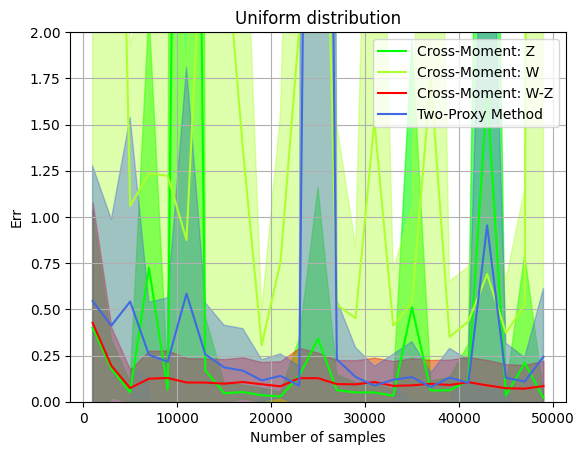

In [27]:
# Plot the results
eps=0.3
plt.title("Uniform distribution")
plt.xlabel("Number of samples")
plt.ylabel("Err")
plt.plot(x, y_est1, label="Cross-Moment: Z", color="lime")
plt.fill_between(x, y_est1 - yerr_est1, y_est1 + yerr_est1, alpha=0.6, color="lime")

plt.plot(x, y_est2, label="Cross-Moment: W", color="greenyellow")
plt.fill_between(x, y_est2 - yerr_est2, y_est2 + yerr_est2, alpha=0.4, color="greenyellow")

plt.plot(x, y_est_sensor_fusion, label="Cross-Moment: W-Z", color="red")
plt.fill_between(x, y_est_sensor_fusion - yerr_est_sensor_fusion, y_est_sensor_fusion + yerr_est_sensor_fusion, alpha=0.4, color="red")

plt.plot(x, y_est_2proxies, label="Two-Proxy Method", color="royalblue")
plt.fill_between(x, y_est_2proxies - yerr_est_2proxies, y_est_2proxies + yerr_est_2proxies, alpha=0.4, color="royalblue")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 2)
plt.savefig("./figures/uniform_comparison_2proxies.png")
plt.show()

#### Performance vs SNR rate ($W$)

In [28]:
from src.cross_moment import get_beta, get_beta_2proxies, get_beta_sensor_fusion

In [29]:
dist_name = "Uniform"
seed = 26
deg = 3
np.random.seed(seed)

num_points = 25
n_samples = 10000

betas_true = np.zeros(10, dtype=float)
betas_est1 = {}
betas_est2 = {}
betas_est_sensor_fusion = {}
betas_est_2proxies = {}
betas_est_best = {}
scale_noise = 0.1
scale_noise_Z = 0.1
max_ratio = 20
for i in range(10):
    alpha_d, alpha_z, beta, gamma = 0, 0, 0, 0
    while abs(alpha_d) < 0.2:
        alpha_d = -2 + 4 * np.random.rand()

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        alpha_z = alpha_d * scale

    scale = 0
    while abs(scale) < 0.2:
        scale = -2 + 4 * np.random.rand()
        beta = alpha_d * scale

    scale = 0
    while abs(scale) < 0.5 or abs(scale) > 2:
        scale = -2 + 4 * np.random.rand()
        gamma = alpha_z * scale
        
    betas_true[i] = beta

    for scale_noise_W in np.linspace(1, max_ratio, num=num_points):
        seed = np.random.randint(1000)
        
        # Initialize variances randomly
        var_u, var_d, var_z, var_w, var_y = 0, 0, 0, 0, 0
        while var_u < 1/3:
            var_u = 1 / 3 * 100 * np.random.rand()
        var_d = scale_noise * var_u
        var_z = scale_noise_Z * var_u
        var_y = scale_noise * var_u
        var_w = scale_noise_W * var_u

        radius_u = np.sqrt(var_u * 12)
        radius_d = np.sqrt(var_d * 12)
        radius_z = np.sqrt(var_z * 12)
        radius_w = np.sqrt(var_w * 12)
        radius_y = np.sqrt(var_y * 12)
        
        dist_param = {
            "U": {"low": -radius_u, "high": radius_u},
            "D": {"low": -radius_d, "high": radius_d},
            "Z": {"low": -radius_z, "high": radius_z},
            "Y": {"low": -radius_y, "high": radius_y},
        }
        dist_conf = (dist_name, dist_param)

        # Get synthetic data
        artific_dataset = ArtificialDataset(alpha_z, alpha_d, beta, gamma, n_samples, dist_conf, seed)
        Z = artific_dataset.Z.numpy()
        D = artific_dataset.D.numpy()
        Y = artific_dataset.Y.numpy()
        eps_u = artific_dataset.eps_u.numpy()

        dist_w = torch.distributions.uniform.Uniform(low=-radius_w, high=radius_w)
        eps_w = dist_w.sample([n_samples]).numpy()
        eps_w -= np.mean(eps_w)
        W = eps_u*alpha_z + eps_w

        # Estimate beta with Z
        beta_est1 = get_beta(Z, D, Y, deg)
        if scale_noise_W not in betas_est1.keys():
            betas_est1[scale_noise_W] = []
        betas_est1[scale_noise_W].append(beta_est1)

        # Estimate beta with W
        beta_est2 = get_beta(W, D, Y, deg)
        if scale_noise_W not in betas_est2.keys():
            betas_est2[scale_noise_W] = []
        betas_est2[scale_noise_W].append(beta_est2)

        # Estimate beta with cross-moments sensor fusion
        betas_sensor_fusion = get_beta_sensor_fusion(W, Z, D, Y, deg)
        if scale_noise_W not in betas_est_sensor_fusion.keys():
            betas_est_sensor_fusion[scale_noise_W] = []
        betas_est_sensor_fusion[scale_noise_W].append(betas_sensor_fusion)

        # Estimate beta with two-proxy method
        if scale_noise_W not in betas_est_2proxies.keys():
            betas_est_2proxies[scale_noise_W] = []
        beta_est_2proxies = get_beta_2proxies(Z, W, D, Y)
        betas_est_2proxies[scale_noise_W].append(beta_est_2proxies)

In [30]:
# Preprocess data to make a plot
x = list(np.linspace(1, max_ratio, num=num_points))

y_est1 = np.zeros(len(x))
yerr_est1 = np.zeros(len(x))

y_est2 = np.zeros(len(x))
yerr_est2 = np.zeros(len(x))

y_est_sensor_fusion = np.zeros(len(x))
yerr_est_sensor_fusion = np.zeros(len(x))

y_est_2proxies = np.zeros(len(x))
yerr_est_2proxies = np.zeros(len(x))

for i, scale_noise_W in enumerate(np.linspace(1, max_ratio, num=num_points)):
    x[i] = scale_noise_W
    
    estimates = np.abs((np.array(betas_est1[scale_noise_W]) - betas_true) / betas_true)
    y_est1[i] = np.mean(estimates)
    yerr_est1[i] = np.std(estimates)
    
    estimates = np.abs((np.array(betas_est2[scale_noise_W]) - betas_true) / betas_true)
    y_est2[i] = np.mean(estimates)
    yerr_est2[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_sensor_fusion[scale_noise_W]) - betas_true) / betas_true)
    y_est_sensor_fusion[i] = np.mean(estimates)
    yerr_est_sensor_fusion[i] = np.std(estimates)

    estimates = np.abs((np.array(betas_est_2proxies[scale_noise_W]) - betas_true) / betas_true)
    y_est_2proxies[i] = np.mean(estimates)
    yerr_est_2proxies[i] = np.std(estimates)

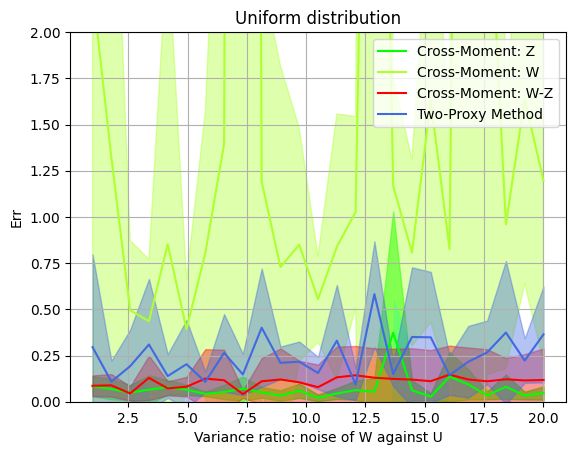

In [31]:
# Plot the results
eps=0.3
plt.title("Uniform distribution")
plt.xlabel("Variance ratio: noise of W against U")
plt.ylabel("Err")
plt.plot(x, y_est1, label="Cross-Moment: Z", color="lime")
plt.fill_between(x, y_est1 - yerr_est1, y_est1 + yerr_est1, alpha=0.6, color="lime")

plt.plot(x, y_est2, label="Cross-Moment: W", color="greenyellow")
plt.fill_between(x, y_est2 - yerr_est2, y_est2 + yerr_est2, alpha=0.4, color="greenyellow")

plt.plot(x, y_est_sensor_fusion, label="Cross-Moment: W-Z", color="red")
plt.fill_between(x, y_est_sensor_fusion - yerr_est_sensor_fusion, y_est_sensor_fusion + yerr_est_sensor_fusion, alpha=0.4, color="red")

plt.plot(x, y_est_2proxies, label="Two-Proxy Method", color="royalblue")
plt.fill_between(x, y_est_2proxies - yerr_est_2proxies, y_est_2proxies + yerr_est_2proxies, alpha=0.4, color="royalblue")

plt.legend(loc="upper right")
plt.grid()
plt.ylim(0, 2)
plt.savefig("./figures/uniform_comparison_2proxies_rate.png")
plt.show()